In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import pandas as pd
import numpy as np
import torch
import datetime
from tqdm import tqdm_notebook
from torch import nn
from torchvision import transforms
from cnn_finetune import make_model

import model2 as M
import unet_parts
from dataset import SegmentationDataset, SegmentationInferenceDataset
from data import *
from util import *
from loss import FocalLoss
from lovasz_loss import lovasz_hinge_flat, lovasz_hinge

In [3]:
torch.cuda.is_available()
device = torch.device('cuda')

# Setup Dataset

In [4]:
train_df, val_df, _ = get_dfs()

In [5]:
train_dataset = SegmentationDataset(train_df, size=(128, 128),
                                    use_depth_channels=True,
                                    with_aux_label=True,
                                    use_augmentation=True)
val_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128),
                                           use_depth_channels=True, with_aux_label=False, with_gt=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

Use augmentations


# Training

In [6]:
gc.collect()
torch.cuda.empty_cache()

weight = torch.load(str(model_dir / 'unet_res34_hcaux_lovaszloss_ft_lr0001_dict.model'))
model = M.UNetRes34HcAuxSCSEv2(n_classes=1)
model.load_state_dict(weight, strict=False)
model = model.to(device)

#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters())

Loaded pretrained resnet weights


In [7]:
def criterion(logit, logit_pixel, logit_feat, target_pixel, target_label):
    segmentation_loss = lovasz_hinge(logit.squeeze(), target_pixel.squeeze(), per_image=False)
    hc_loss = lovasz_hinge(logit_pixel.squeeze(), target_pixel.squeeze(), per_image=False)
    classification_loss = F.cross_entropy(logit_feat, target_label)
    
    return segmentation_loss + 0.5 * hc_loss + 0.05 * classification_loss

In [8]:
def train(model, n_epoch, train_iter, val_iter):
    for epoch in range(n_epoch):
        model.train()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        total_loss = 0
        total_size = 0
        
        for batch_idx, (data, target, label) in enumerate(train_iter):
            data, target, label = data.to(device), target.to(device), label.to(device)
            optimizer.zero_grad()
            
            # Forward
            logit, logit_pixel, logit_feat = model(data)
            loss = criterion(logit, logit_pixel, logit_feat, target, label)
            
            total_loss += loss.item()
            total_size += data.size(0)
            
            # Backward
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                now = datetime.datetime.now()
                print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                    now,
                    epoch, batch_idx * len(data), len(train_iter.dataset),
                    100. * batch_idx / len(train_iter), total_loss / total_size))
                
        gc.collect()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            iou = evaluate(model, val_iter, device=device, use_sigmoid=False, threshold=0.0)
            #iou = evaluate(model, val_iter, device=device, use_sigmoid=True, threshold=0.5)
        print('[{}] Train Epoch: {}\tIoU: {:.6f}'.format(now, epoch, iou))
    return model

In [9]:
model = train(model, 20, train_loader, val_loader)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


[2018-10-12 21:07:36.730163] Train Epoch: 0 [0/3200 (0%)]	Average loss: 0.231216
[2018-10-12 21:07:53.214027] Train Epoch: 0 [400/3200 (12%)]	Average loss: 0.213556
[2018-10-12 21:08:09.693396] Train Epoch: 0 [800/3200 (25%)]	Average loss: 0.207985
[2018-10-12 21:08:26.173838] Train Epoch: 0 [1200/3200 (38%)]	Average loss: 0.205377
[2018-10-12 21:08:42.668245] Train Epoch: 0 [1600/3200 (50%)]	Average loss: 0.204166
[2018-10-12 21:08:59.143833] Train Epoch: 0 [2000/3200 (62%)]	Average loss: 0.202896
[2018-10-12 21:09:15.624164] Train Epoch: 0 [2400/3200 (75%)]	Average loss: 0.201623
[2018-10-12 21:09:32.062224] Train Epoch: 0 [2800/3200 (88%)]	Average loss: 0.200992
[2018-10-12 21:09:32.062224] Train Epoch: 0	IoU: 0.378375
[2018-10-12 21:10:00.671099] Train Epoch: 1 [0/3200 (0%)]	Average loss: 0.195483
[2018-10-12 21:10:17.138242] Train Epoch: 1 [400/3200 (12%)]	Average loss: 0.194053
[2018-10-12 21:10:33.592769] Train Epoch: 1 [800/3200 (25%)]	Average loss: 0.194158
[2018-10-12 21:10:5

[2018-10-12 21:34:16.566159] Train Epoch: 11 [400/3200 (12%)]	Average loss: 0.192069
[2018-10-12 21:34:33.053317] Train Epoch: 11 [800/3200 (25%)]	Average loss: 0.191823
[2018-10-12 21:34:49.522193] Train Epoch: 11 [1200/3200 (38%)]	Average loss: 0.191832
[2018-10-12 21:35:05.984061] Train Epoch: 11 [1600/3200 (50%)]	Average loss: 0.191931
[2018-10-12 21:35:22.446713] Train Epoch: 11 [2000/3200 (62%)]	Average loss: 0.192043
[2018-10-12 21:35:38.955313] Train Epoch: 11 [2400/3200 (75%)]	Average loss: 0.192008
[2018-10-12 21:35:55.486652] Train Epoch: 11 [2800/3200 (88%)]	Average loss: 0.191958
[2018-10-12 21:35:55.486652] Train Epoch: 11	IoU: 0.374000
[2018-10-12 21:36:24.060498] Train Epoch: 12 [0/3200 (0%)]	Average loss: 0.190761
[2018-10-12 21:36:40.555130] Train Epoch: 12 [400/3200 (12%)]	Average loss: 0.192007
[2018-10-12 21:36:57.076076] Train Epoch: 12 [800/3200 (25%)]	Average loss: 0.192099
[2018-10-12 21:37:13.570434] Train Epoch: 12 [1200/3200 (38%)]	Average loss: 0.192114
[20

KeyboardInterrupt: 

In [10]:
save_model(model, 'unet_res34_hcauxscsev2_aug')

In [11]:
val_check_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128), with_gt=True, with_raw_input=True, use_depth_channels=True)
val_check_loader = torch.utils.data.DataLoader(val_check_dataset, batch_size=8, shuffle=False)
val_check_iter = iter(val_check_loader)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


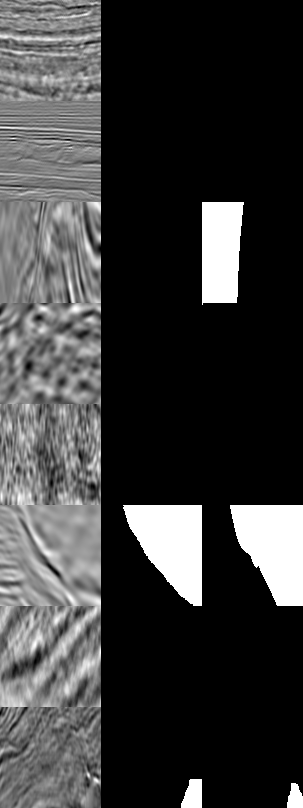

In [12]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


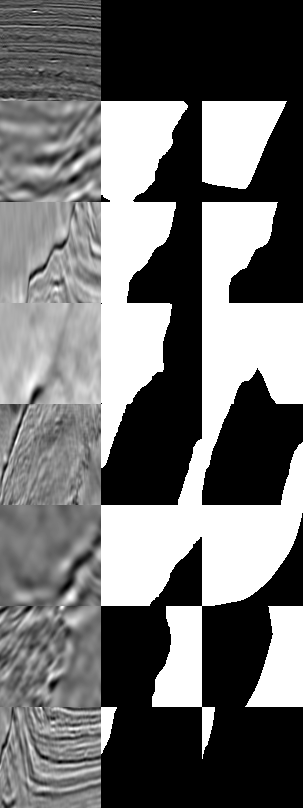

In [13]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


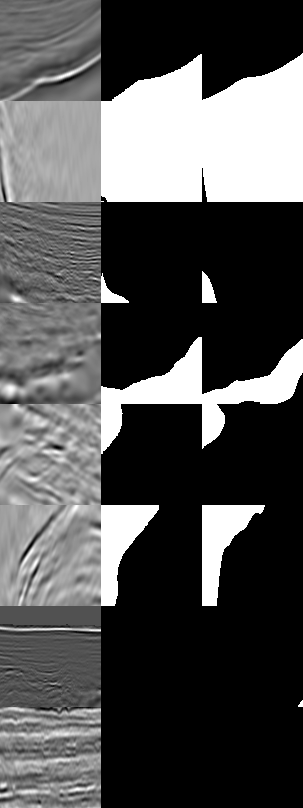

In [14]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


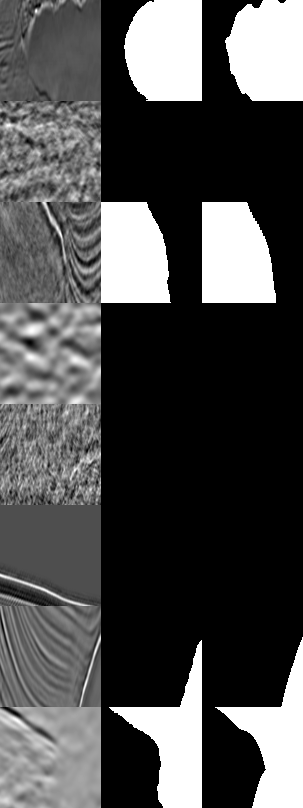

In [15]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)